In [1]:
#Import libraries
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from scipy import sparse
import numpy as np
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
import obonet
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from pyensembl import EnsemblRelease
import statistics

In [ ]:
# Read in methylation data, the path refers to the summarized beta value table file
beta_value = pd.read_csv('./../data/GEO/all_betavalues_2.txt', sep = '\t', engine = 'python')
# Read in sample annotation file
metadata_value=pd.read_csv('./../annotation/GEO_metadata_test2.txt', sep = '\t', engine = 'python')
# Read in bto ontology tree annotation file
tissue_ontology_tree=obonet.read_obo('./../annotation/bto.obo')

In [10]:
# Check the completeness of the table (num of loci * num of samples)
print(beta_value.shape)

(441683, 4184)


In [11]:
beta_value_copy=beta_value

In [5]:
# Filter out all loci that are on X or Y chromosome
index_names1=beta_value[beta_value['V1']=='chrX'].index
index_names2=beta_value[beta_value['V1']=='chrY'].index
index_names=index_names1.append(index_names2)
beta_value.drop(index_names, inplace=True)
beta_value.reset_index(drop=True)

,V1,V2,GSM2722207,GSM2722208,GSM2722209,GSM2722210,GSM2722211,GSM2722212,GSM2722213,GSM2722214,...,GSM4744542,GSM4744543,GSM4744544,GSM4744545,GSM4744546,GSM4744547,GSM4744548,GSM4744549,GSM4744550,GSM4744551
0,chr1,15865,0.859735,0.795350,0.829810,0.817747,0.817979,0.829120,0.343473,0.845935,...,0.863749,0.491224,0.573217,0.515879,0.841976,0.505419,0.587472,0.570868,0.521442,0.497001
1,chr1,18827,0.639892,0.721035,0.805947,0.754453,0.696233,0.731427,0.478688,0.668714,...,0.038404,0.486002,0.492570,0.486438,0.030096,0.493775,0.511536,0.481241,0.499423,0.505217
2,chr1,29407,0.110878,0.101088,0.114969,0.108208,0.049414,0.049073,0.023540,0.037248,...,0.860040,0.506763,0.480434,0.512227,0.778615,0.485401,0.521059,0.486044,0.476188,0.456766
3,chr1,29425,0.364476,0.368387,0.358243,0.372815,0.029355,0.061376,0.073050,0.018145,...,0.033191,0.532776,0.507077,0.516247,0.041378,0.504737,0.517408,0.498653,0.518176,0.497891
4,chr1,68849,0.374719,0.385438,0.363766,0.363268,0.020888,0.021241,0.052451,0.018179,...,0.044681,0.247842,0.308801,0.310672,0.067075,0.271058,0.242430,0.268098,0.289527,0.246295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441678,chr22,50783823,0.783969,0.781589,0.836449,0.806592,0.766104,0.819458,0.033633,0.773476,...,0.073809,0.067859,0.078900,0.085485,0.065296,0.063605,0.069775,0.072978,0.069714,0.095081
441679,chr22,50784091,0.895413,0.917838,0.889114,0.918503,0.871991,0.922358,0.672290,0.934979,...,0.965177,0.973390,0.933843,0.966164,0.948289,0.962628,0.967626,0.973445,0.968628,0.975594
441680,chr22,50784301,0.159308,0.138837,0.117219,0.117949,0.210904,0.193039,0.012879,0.132978,...,0.133379,0.117444,0.124169,0.122796,0.146985,0.142488,0.140454,0.136440,0.138450,0.144799
441681,chr22,50784915,0.965399,0.894990,0.915395,0.924111,0.944223,0.937769,0.995051,0.966040,...,0.688452,0.745294,0.709841,0.718882,0.745543,0.768694,0.740554,0.765744,0.756348,0.752867


In [12]:
# Get all features in the form of 'chr position'
empty=[' ']*len(beta_value)
feature=np.char.array(beta_value['V1'])+np.char.array(empty)
feature=np.char.array(feature)+np.char.array(list(map(str, beta_value['V2'])))

In [88]:
#Get samples with both methylation data and metadata annotation
beta_samples=list(beta_value.columns)[2:]
metadata_samples=metadata_value['sample_id']
overlap=[]
for i in metadata_samples:
    if i in beta_samples:
        overlap.append(i)
disease_term=metadata_value['disease_name']
tissue_term=metadata_value['tissue_name']

In [89]:
#Remove overlapping samples (the names were found manually, so this step should be skipped if there is no repetitive samples in the beta value matrix)
index_to_delete=['GSM3813550', 'GSM3813542', 'GSM3813555', 'GSM3813541', 'GSM3813540']
for i in index_to_delete:
    overlap.remove(i)

In [80]:
X=beta_value[overlap]

In [91]:
# Filtering based on disease term to get the normal samples (here cell lines were excluded)
normal_sample=[metadata_value['sample_id'][i] for i in range(0,len(disease_term)) if ((disease_term[i]=='normal' or disease_term[i]=='adjacent normal') and (tissue_term[i]!='embryonic stem cell line' and tissue_term[i]!='MDA-MB-436 cell') and metadata_value['sample_id'][i] in overlap)]
normal_sample_index=[i for i in range(0,len(disease_term)) if ((disease_term[i]=='normal' or disease_term[i]=='adjacent normal') and (tissue_term[i]!='embryonic stem cell line' and tissue_term[i]!='MDA-MB-436 cell') and metadata_value['sample_id'][i] in overlap)]
normal_sample_value=metadata_value['tissue_name'][normal_sample_index]

In [18]:
# Create bto id and tissue name dictionaries
name_to_id = { id_:data.get('name') for id_, data in tissue_ontology_tree.nodes(data=True)}
id_to_name = { data.get('name'):id_ for id_, data in tissue_ontology_tree.nodes(data=True)}

In [ ]:
# Get the correponding nodes of all metadata (selected_nodes) and all the nodes that connect them into a DAG (completed node)
def create_subgraph(tissue_ontology_tree,normal_sample_value):
    id_to_name = { data.get('name'):id_ for id_, data in tissue_ontology_tree.nodes(data=True)}
    selected_nodes=list(id_to_name[x] for x in list(set(normal_sample_value)))
    completed_nodes=[]
    for node_element in selected_nodes:
        print(node_element)
        completed_nodes=completed_nodes+list(nx.ancestors(tissue_ontology_tree,node_element))
    completed_nodes=completed_nodes+selected_nodes
    return(completed_nodes)

In [ ]:
completed_nodes=create_subgraph(tissue_ontology_tree,normal_sample_value)

In [ ]:
# Create subgraph containing all metadata values
tissue_subgraph=tissue_ontology_tree.subgraph(completed_nodes)
#plt.title('draw_networkx')
#pos=graphviz_layout(tissue_subgraph, prog='dot')
#nx.draw(tissue_subgraph, pos, with_labels=True, arrows=True)


In [ ]:
nx.draw(tissue_subgraph,pos=nx.circular_layout(tissue_subgraph, scale=5),with_labels=True,font_size=8)

In [ ]:
print(nx.is_weakly_connected(tissue_subgraph))

In [ ]:
print(tissue_subgraph.edges())
print(tissue_subgraph.nodes())
print(list(name_to_id[i] for i in list(tissue_subgraph.nodes())))

In [19]:
# Create binary classifier Y values 
def get_indicator_matrix(node):
    id_node=id_to_name[node]
    ancestor_nodes=[i for i in normal_sample_index if id_to_name[metadata_value['tissue_name'][i]] in nx.descendants(tissue_ontology_tree, id_node)]
    print(ancestor_nodes)
    positive_sample_index=[i for i in normal_sample_index if id_to_name[metadata_value['tissue_name'][i]] not in nx.descendants(tissue_ontology_tree, id_node) and (id_to_name[metadata_value['tissue_name'][i]] in nx.ancestors(tissue_ontology_tree, id_node) or id_to_name[metadata_value['tissue_name'][i]]==id_node)]
    y_matrix=np.zeros(((len(metadata_value['tissue_name'])), 1))
    y_matrix[positive_sample_index]=1
    samples_keep=list(set(normal_sample_index)-set(ancestor_nodes))
    y_matrix_sample=y_matrix[samples_keep]
    return(y_matrix_sample,samples_keep,positive_sample_index)

In [ ]:
[x,y,z]=get_indicator_matrix('peripheral blood')

In [20]:
data = EnsemblRelease(77)

In [92]:
print(set(normal_sample_value))

{'umbilical cord blood', 'vastus lateralis', 'naive T-lymphocyte', 'urine', 'pancreas', 'buccal mucosa', 'prostate gland', 'adrenal gland', 'blood plasma', 'bronchoalveolar lavage fluid', 'monocyte', 'liver', 'colon', 'saliva', 'breast epithelial cell', 'NCI-H1299 cell', 'blood', 'skin', 'skin fibroblast', 'thyroid gland', 'colorectum', 'peripheral blood mononuclear cell', 'memory T-lymphocyte', 'peripheral blood'}


umbilical cord blood
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


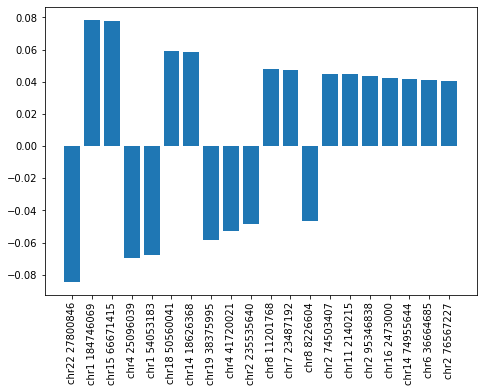

AUC:0.9994936606311013
vastus lateralis
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[53.]
[25.]
[78.]
Accuracy: 0.9902200488997555
[[], ['RNF152'], ['GAB1'], [], ['TMEM189-UBE2V1', 'UBE2V1'], ['RPH3AL'], [], [], ['OSMR'], [], [], ['LZTS3'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['RP11-666A8.8'], [], ['C7orf50', 'GPER1'], ['FCGRT'], ['HINFP'], []]
[[], ['ENSG00000176641'], ['ENSG00000109458'], [], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000181031'], [], [], ['ENSG00000145623'], [], [], ['ENSG00000088899'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000267546'], [], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000104870'], ['ENSG00000172273'], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


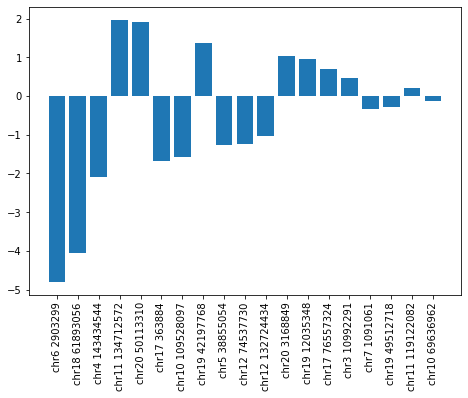

AUC:0.999344262295082
naive T-lymphocyte
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


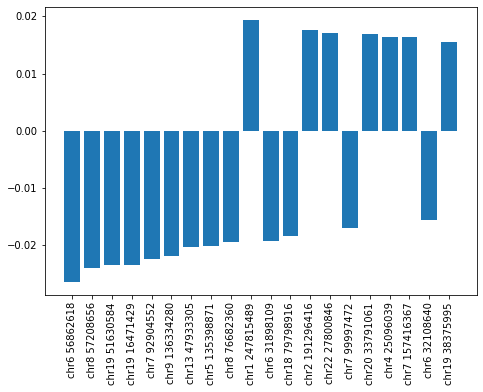

AUC:1.0
urine
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[3.]
[1.]
[4.]
Accuracy: 0.9987775061124694
[[], [], ['TMEM189-UBE2V1', 'UBE2V1'], [], ['HINFP'], [], [], ['LZTS3'], ['OSMR'], [], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['RPH3AL'], ['GAB1'], ['RNF152'], ['C7orf50', 'GPER1'], ['FCGRT'], [], ['RP11-666A8.8']]
[[], [], ['ENSG00000124208', 'ENSG00000244687'], [], ['ENSG00000172273'], [], [], ['ENSG00000088899'], ['ENSG00000145623'], [], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000181031'], ['ENSG00000109458'], ['ENSG00000176641'], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000104870'], [], ['ENSG00000267546']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


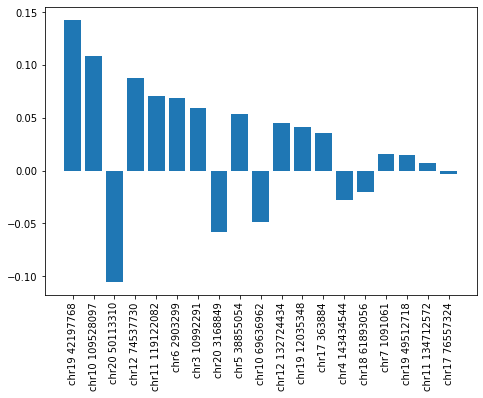

AUC:1.0
pancreas
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[5.]
[4.]
[9.]
Accuracy: 0.9951100244498777
[['FCGRT'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['LZTS3'], ['RNF152'], [], ['TMEM189-UBE2V1', 'UBE2V1'], [], ['GAB1'], ['RP11-666A8.8'], [], [], [], ['C7orf50', 'GPER1'], ['OSMR'], ['HINFP'], ['RPH3AL'], [], []]
[['ENSG00000104870'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000088899'], ['ENSG00000176641'], [], ['ENSG00000124208', 'ENSG00000244687'], [], ['ENSG00000109458'], ['ENSG00000267546'], [], [], [], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000145623'], ['ENSG00000172273'], ['ENSG00000181031'], [], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


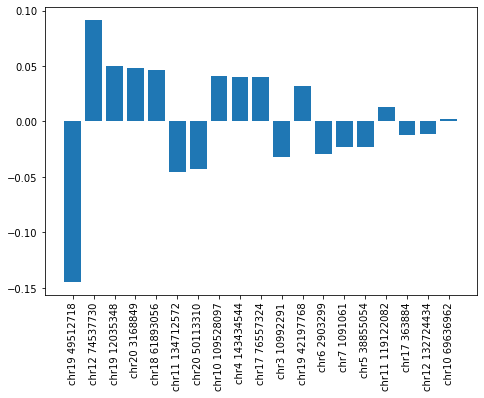

AUC:0.9981572481572482
buccal mucosa
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[35.]
[13.]
[48.]
Accuracy: 0.9841075794621027
[['RNF152'], [], ['HINFP'], [], [], ['GAB1'], [], [], [], ['RPH3AL'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['LZTS3'], [], ['RP11-666A8.8'], ['FCGRT'], ['TMEM189-UBE2V1', 'UBE2V1'], ['C7orf50', 'GPER1'], ['OSMR']]
[['ENSG00000176641'], [], ['ENSG00000172273'], [], [], ['ENSG00000109458'], [], [], [], ['ENSG00000181031'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000088899'], [], ['ENSG00000267546'], ['ENSG00000104870'], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000145623']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


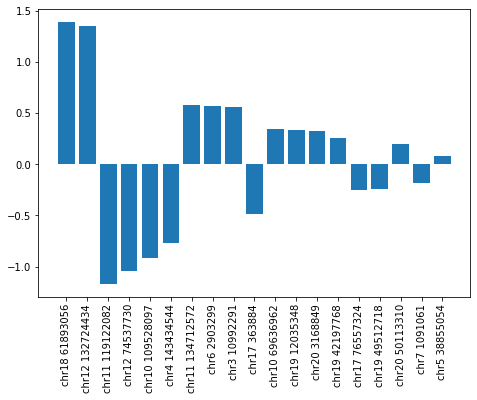

AUC:0.9978021978021978
prostate gland
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[4.]
[0.]
[4.]
Accuracy: 1.0
[[], ['RP11-666A8.8'], [], ['HINFP'], [], ['GAB1'], ['OSMR'], ['RNF152'], [], ['RPH3AL'], ['FCGRT'], ['LZTS3'], [], [], [], [], ['TMEM189-UBE2V1', 'UBE2V1'], ['C7orf50', 'GPER1'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433']]
[[], ['ENSG00000267546'], [], ['ENSG00000172273'], [], ['ENSG00000109458'], ['ENSG00000145623'], ['ENSG00000176641'], [], ['ENSG00000181031'], ['ENSG00000104870'], ['ENSG00000088899'], [], [], [], [], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


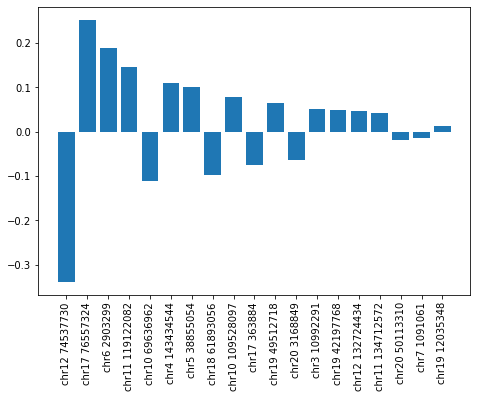

AUC:nan
adrenal gland


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[5.]
[7.]
[12.]
Accuracy: 1.0
[[], ['RPH3AL'], [], ['OSMR'], [], [], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['GAB1'], [], [], ['FCGRT'], ['RNF152'], [], ['LZTS3'], ['C7orf50', 'GPER1'], ['HINFP'], ['TMEM189-UBE2V1', 'UBE2V1'], ['RP11-666A8.8']]
[[], ['ENSG00000181031'], [], ['ENSG00000145623'], [], [], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000109458'], [], [], ['ENSG00000104870'], ['ENSG00000176641'], [], ['ENSG00000088899'], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000172273'], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000267546']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


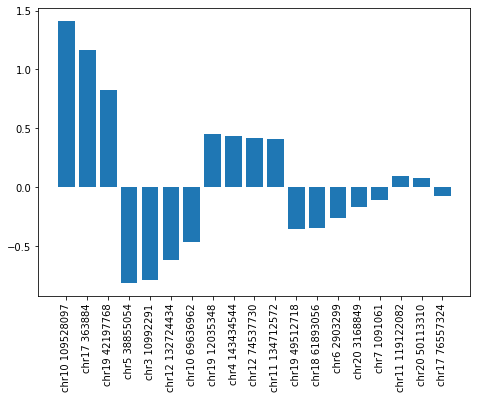

AUC:1.0
blood plasma
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


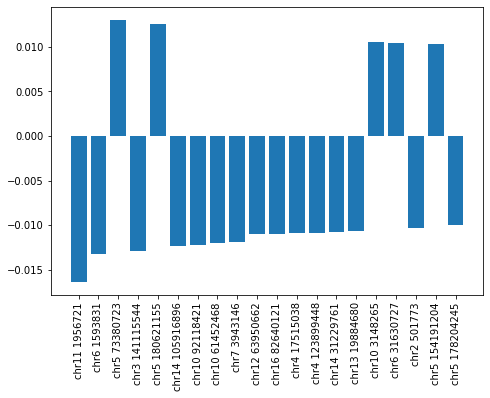

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


AUC:nan
bronchoalveolar lavage fluid
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[32.]
[12.]
[44.]
Accuracy: 0.988997555012225
[[], ['OSMR'], [], ['GAB1'], [], ['FCGRT'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], [], ['TMEM189-UBE2V1', 'UBE2V1'], [], [], ['RNF152'], [], ['HINFP'], ['LZTS3'], ['RP11-666A8.8'], ['RPH3AL'], ['C7orf50', 'GPER1']]
[[], ['ENSG00000145623'], [], ['ENSG00000109458'], [], ['ENSG00000104870'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], [], ['ENSG00000124208', 'ENSG00000244687'], [], [], ['ENSG00000176641'], [], ['ENSG00000172273'], ['ENSG00000088899'], ['ENSG00000267546'], ['ENSG00000181031'], ['ENSG00000146540', 'ENSG00000164850']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


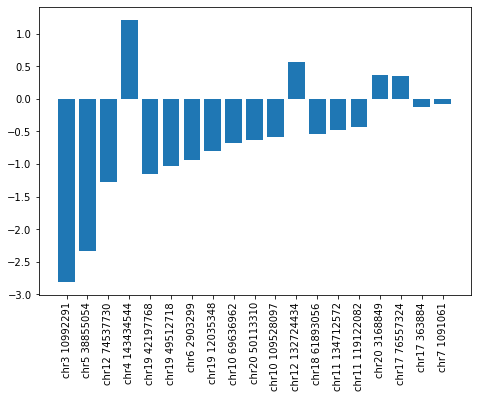

AUC:0.9992762613730355
monocyte
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[['PARPBP'], ['PRKAR1B'], [], [], ['MAFK', 'TMEM184A'], ['SAP130'], ['RP11-95P2.1'], ['GAL3ST3'], [], ['STMN2'], ['CCR10'], [], ['DSCAML1'], [], [], ['MAP3K13'], ['TRIM33'], ['CADM3'], ['BTBD7'], ['AC005785.2', 'AKAP8']]
[['ENSG00000185480'], ['ENSG00000188191'], [], [], ['ENSG00000164855', 'ENSG00000198517'], ['ENSG00000136715'], ['ENSG00000262468'], ['ENSG00000175229'], [], ['ENSG00000104435'], ['ENSG00000184451'], [], ['ENSG00000177103'], [], [], ['ENSG00000073803'], ['ENSG00000197323'], ['ENSG00000162706'], ['ENSG00000011114'], ['ENSG00000105127', 'ENSG00000268189']]


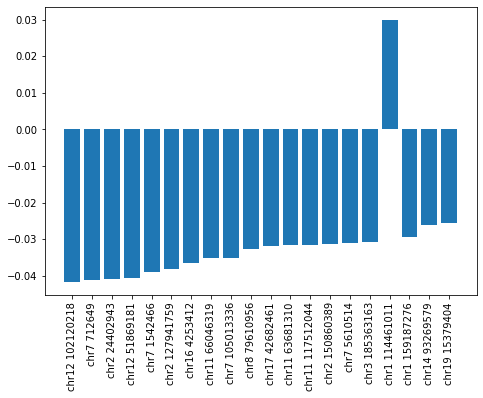

AUC:1.0
liver
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[17.]
[9.]
[26.]
Accuracy: 0.9987775061124694
[['OSMR'], ['C7orf50', 'GPER1'], [], [], ['FCGRT'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], [], ['LZTS3'], ['RNF152'], [], [], [], ['RPH3AL'], ['HINFP'], [], ['GAB1'], ['RP11-666A8.8'], ['TMEM189-UBE2V1', 'UBE2V1'], []]
[['ENSG00000145623'], ['ENSG00000146540', 'ENSG00000164850'], [], [], ['ENSG00000104870'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], [], ['ENSG00000088899'], ['ENSG00000176641'], [], [], [], ['ENSG00000181031'], ['ENSG00000172273'], [], ['ENSG00000109458'], ['ENSG00000267546'], ['ENSG00000124208', 'ENSG00000244687'], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


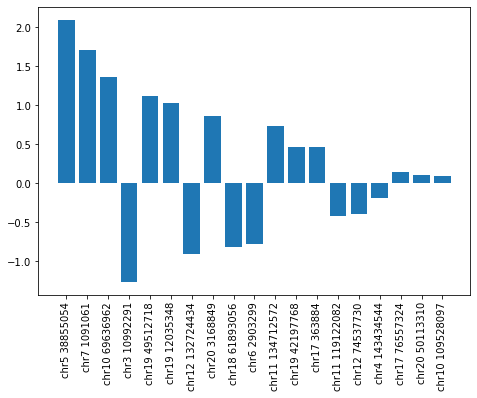

AUC:0.9951929679989012
colon
[927, 930, 933, 936, 938, 940, 942, 944, 946, 949, 952, 955, 958, 960, 964, 967, 969, 972, 974, 977]
(2456, 1)
(2456, 441683)
8
chr11 134712572
[8.]
[4.]
[12.]
Accuracy: 0.9950678175092479
[[], [], [], ['FCGRT'], ['TMEM189-UBE2V1', 'UBE2V1'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['HINFP']]
[[], [], [], ['ENSG00000104870'], ['ENSG00000124208', 'ENSG00000244687'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000172273']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


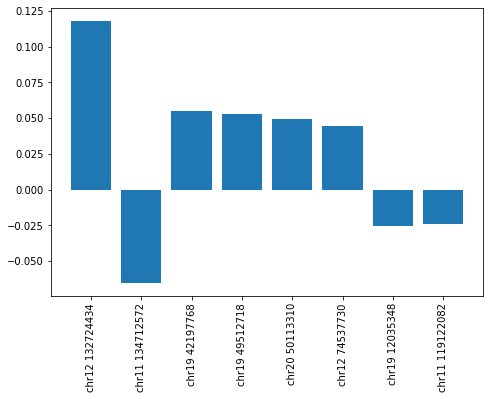

AUC:0.8308550185873607
saliva
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[69.]
[31.]
[100.]
Accuracy: 0.9877750611246944
[[], ['OSMR'], [], [], [], ['RNF152'], ['FCGRT'], ['GAB1'], ['C7orf50', 'GPER1'], [], ['RP11-666A8.8'], ['RPH3AL'], [], [], ['LZTS3'], ['HINFP'], [], ['TMEM189-UBE2V1', 'UBE2V1'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433']]
[[], ['ENSG00000145623'], [], [], [], ['ENSG00000176641'], ['ENSG00000104870'], ['ENSG00000109458'], ['ENSG00000146540', 'ENSG00000164850'], [], ['ENSG00000267546'], ['ENSG00000181031'], [], [], ['ENSG00000088899'], ['ENSG00000172273'], [], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


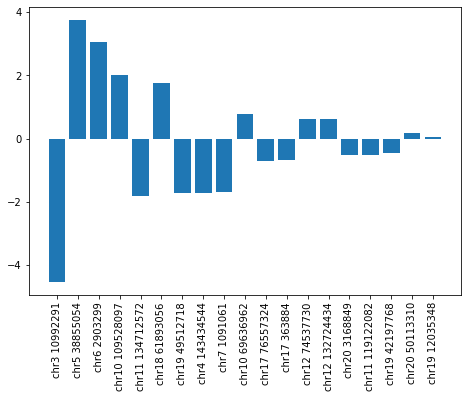

AUC:0.9259335164159528
breast epithelial cell
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[9.]
[8.]
[17.]
Accuracy: 0.9975550122249389
[['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['RNF152'], [], [], [], ['C7orf50', 'GPER1'], [], [], ['LZTS3'], ['FCGRT'], ['RPH3AL'], ['TMEM189-UBE2V1', 'UBE2V1'], ['OSMR'], ['HINFP'], ['RP11-666A8.8'], ['GAB1'], [], [], []]
[['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000176641'], [], [], [], ['ENSG00000146540', 'ENSG00000164850'], [], [], ['ENSG00000088899'], ['ENSG00000104870'], ['ENSG00000181031'], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000145623'], ['ENSG00000172273'], ['ENSG00000267546'], ['ENSG00000109458'], [], [], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


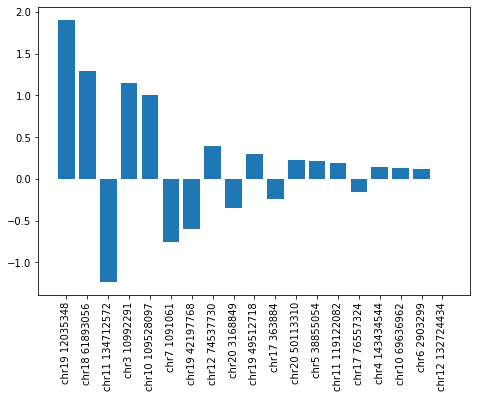

AUC:1.0
NCI-H1299 cell
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[8.]
[1.]
[9.]
Accuracy: 1.0
[['RPH3AL'], ['RNF152'], [], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], [], [], ['LZTS3'], ['FCGRT'], [], [], ['GAB1'], ['TMEM189-UBE2V1', 'UBE2V1'], [], ['C7orf50', 'GPER1'], [], ['RP11-666A8.8'], ['OSMR'], ['HINFP']]
[['ENSG00000181031'], ['ENSG00000176641'], [], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], [], [], ['ENSG00000088899'], ['ENSG00000104870'], [], [], ['ENSG00000109458'], ['ENSG00000124208', 'ENSG00000244687'], [], ['ENSG00000146540', 'ENSG00000164850'], [], ['ENSG00000267546'], ['ENSG00000145623'], ['ENSG00000172273']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


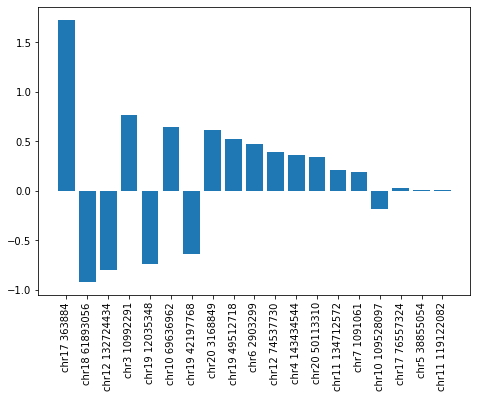

AUC:1.0
blood
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[1383.]
[684.]
[2067.]
Accuracy: 0.9376528117359413
[[], [], ['TMEM189-UBE2V1', 'UBE2V1'], ['RP11-666A8.8'], ['LZTS3'], ['RNF152'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['RPH3AL'], [], [], [], ['FCGRT'], ['OSMR'], ['GAB1'], [], ['C7orf50', 'GPER1'], ['HINFP'], [], []]
[[], [], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000267546'], ['ENSG00000088899'], ['ENSG00000176641'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000181031'], [], [], [], ['ENSG00000104870'], ['ENSG00000145623'], ['ENSG00000109458'], [], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000172273'], [], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


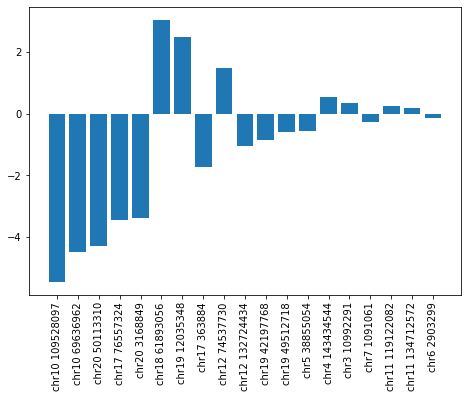

AUC:0.9066073143056647
skin
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[14.]
[8.]
[22.]
Accuracy: 0.991442542787286
[['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['RPH3AL'], ['OSMR'], [], [], [], ['RP11-666A8.8'], [], [], [], ['FCGRT'], ['GAB1'], ['LZTS3'], [], ['TMEM189-UBE2V1', 'UBE2V1'], ['RNF152'], ['HINFP'], [], ['C7orf50', 'GPER1']]
[['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000181031'], ['ENSG00000145623'], [], [], [], ['ENSG00000267546'], [], [], [], ['ENSG00000104870'], ['ENSG00000109458'], ['ENSG00000088899'], [], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000176641'], ['ENSG00000172273'], [], ['ENSG00000146540', 'ENSG00000164850']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


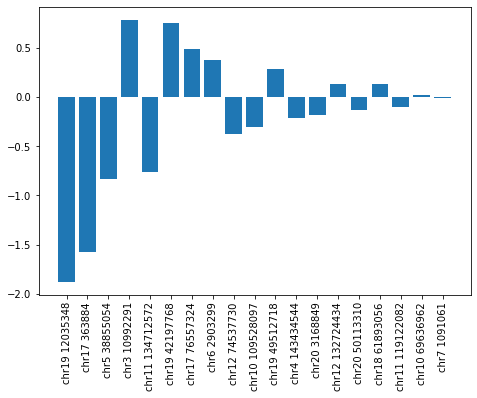

AUC:0.9990740740740741
skin fibroblast
[3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559]
(2460, 1)
(2460, 441683)
16
chr4 143434544
[4.]
[2.]
[6.]
Accuracy: 1.0
[['RPH3AL'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], [], ['C7orf50', 'GPER1'], ['OSMR'], [], [], [], [], ['HINFP'], ['RP11-666A8.8'], ['GAB1'], ['FCGRT'], ['TMEM189-UBE2V1', 'UBE2V1'], []]
[['ENSG00000181031'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], [], ['ENSG00000146540', 'ENSG00000164850'], ['ENSG00000145623'], [], [], [], [], ['ENSG00000172273'], ['ENSG00000267546'], ['ENSG00000109458'], ['ENSG00000104870'], ['ENSG00000124208', 'ENSG00000244687'], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


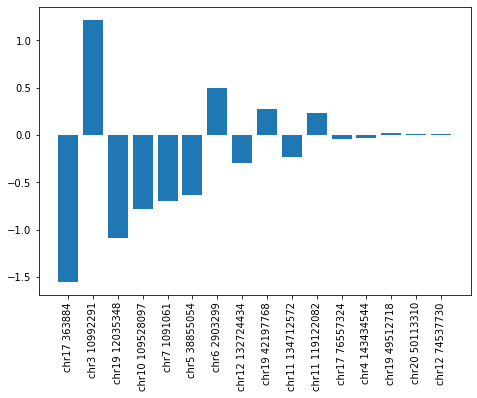

AUC:1.0
thyroid gland
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[1.]
[3.]
[4.]
Accuracy: 0.9963325183374083
[['RP11-666A8.8'], [], ['LZTS3'], [], ['OSMR'], [], [], ['C7orf50', 'GPER1'], [], [], [], ['RNF152'], ['TMEM189-UBE2V1', 'UBE2V1'], ['FCGRT'], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], ['HINFP'], ['GAB1'], [], ['RPH3AL']]
[['ENSG00000267546'], [], ['ENSG00000088899'], [], ['ENSG00000145623'], [], [], ['ENSG00000146540', 'ENSG00000164850'], [], [], [], ['ENSG00000176641'], ['ENSG00000124208', 'ENSG00000244687'], ['ENSG00000104870'], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], ['ENSG00000172273'], ['ENSG00000109458'], [], ['ENSG00000181031']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


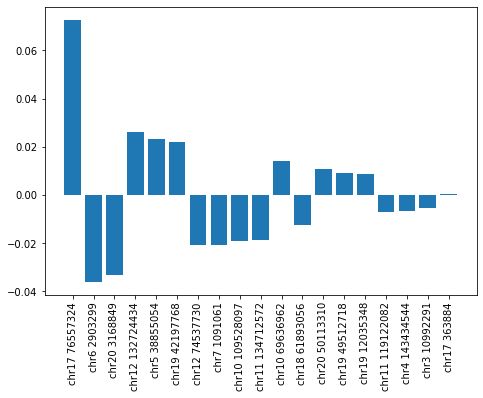

AUC:0.9950920245398773
colorectum
[]
(2476, 1)
(2476, 441683)
19
chr4 143434544
[20.]
[12.]
[32.]
Accuracy: 0.9853300733496333
[[], ['OSMR'], [], ['CTD-2006C1.10', 'CTD-2006C1.2', 'ZNF433'], [], ['RPH3AL'], ['RP11-666A8.8'], ['FCGRT'], [], [], ['C7orf50', 'GPER1'], [], ['RNF152'], ['HINFP'], [], ['GAB1'], ['LZTS3'], [], ['TMEM189-UBE2V1', 'UBE2V1']]
[[], ['ENSG00000145623'], [], ['ENSG00000197647', 'ENSG00000219665', 'ENSG00000257355'], [], ['ENSG00000181031'], ['ENSG00000267546'], ['ENSG00000104870'], [], [], ['ENSG00000146540', 'ENSG00000164850'], [], ['ENSG00000176641'], ['ENSG00000172273'], [], ['ENSG00000109458'], ['ENSG00000088899'], [], ['ENSG00000124208', 'ENSG00000244687']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


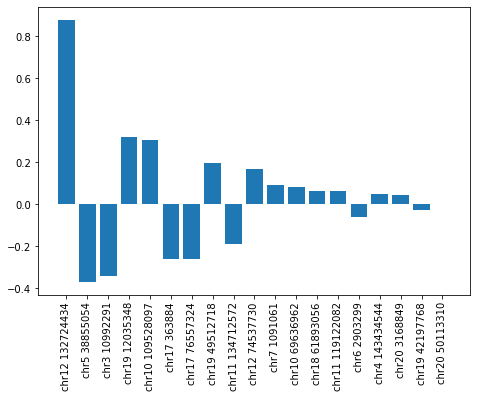

AUC:0.9043631100082713
peripheral blood mononuclear cell
[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


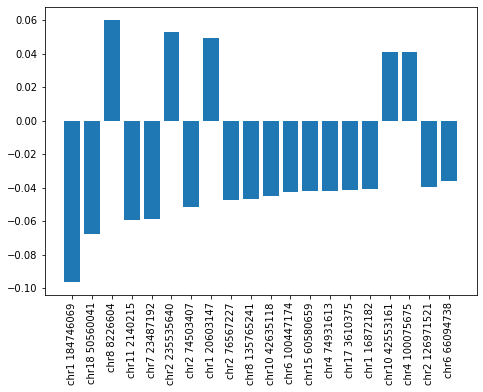

AUC:0.9960221793635488
memory T-lymphocyte
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 15

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[], [], [], ['AC004076.9', 'VN1R1'], ['TRAF3IP2'], ['RNLS'], ['POLR1D'], [], [], ['SLC35G1'], ['PNMA2'], ['C1RL'], ['WDR63'], ['TUBB'], ['WDR86'], ['MZF1', 'MZF1-AS1'], ['ANKRD54'], ['PAX2'], ['NR5A1'], []]
[[], [], [], ['ENSG00000178201', 'ENSG00000268163'], ['ENSG00000056972'], ['ENSG00000184719'], ['ENSG00000186184'], [], [], ['ENSG00000176273'], ['ENSG00000240694'], ['ENSG00000139178'], ['ENSG00000162643'], ['ENSG00000196230'], ['ENSG00000187260'], ['ENSG00000099326', 'ENSG00000267858'], ['ENSG00000100124'], ['ENSG00000075891'], ['ENSG00000136931'], []]


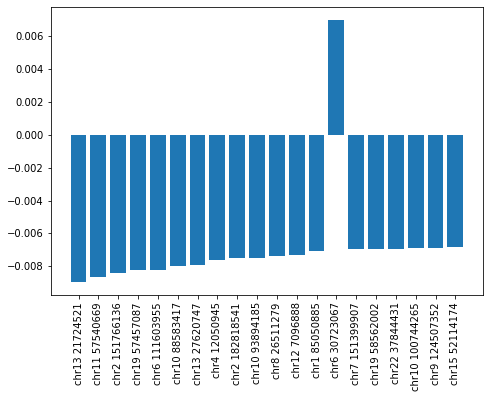

AUC:1.0
peripheral blood
[1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 15

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


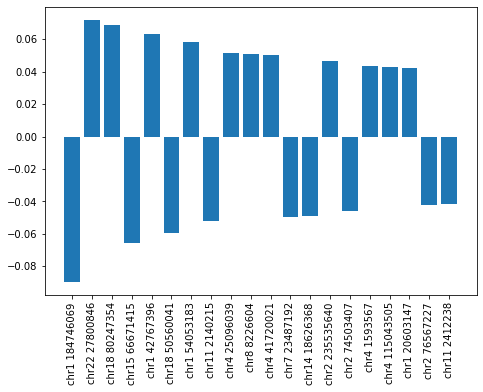

AUC:0.999963963963964


In [102]:
all_genes=dict()
for i in set(normal_sample_value):
    print(i)
    [y_matrix_single, samples_keep, positive_sample]=get_indicator_matrix(i)
    print(y_matrix_single.shape)
    x_matrix_single=beta_value[metadata_value.iloc[samples_keep,0]]
    value_X=np.transpose(np.array(x_matrix_single))
    print(value_X.shape)
    sel = VarianceThreshold(threshold=(0.18))
    filtered_X=sel.fit_transform(value_X)
    mask = sel.get_support(indices=True)
    print(len(mask))
    filtered_labels=list(feature[mask])
    print(filtered_labels[1])
    X_train, X_test, y_train, y_test = train_test_split(filtered_X, y_matrix_single, test_size=0.33, random_state=42)
    print(sum(y_train))
    print(sum(y_test))
    print(sum(y_matrix_single))
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    coefficients=list(clf.coef_[0,:])
    coeffdict={coefficients[i]:filtered_labels[i] for i in range(0, len(coefficients))}
    coordinate_coeffdict={coefficients[i]:mask[i] for i in range(0, len(coefficients))}
    sorted_coeffs=sorted(coefficients, key=abs, reverse=True)
    CpGcoord20=[coordinate_coeffdict[key] for key in sorted_coeffs[0:20]]
    gene_names=[]
    gene_ids=[]
    for j in CpGcoord20:
        chromo=beta_value['V1'][j].split('chr')[1]
        CpGposition=beta_value['V2'][j]
        gene_names.append(data.gene_names_at_locus(contig=chromo, position=int(CpGposition)))
        gene_ids.append(data.gene_ids_at_locus(contig=chromo, position=int(CpGposition)))
    all_genes.update({i:gene_names})
    print(gene_names)
    print(gene_ids)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar([coeffdict[key] for key in sorted_coeffs[0:20]],sorted_coeffs[0:20])
    plt.xticks(rotation=90)
    plt.show()
    #y_prob=clf.predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    print('AUC:'+str(auc(fpr,tpr)))
    # Compute ROC curve and ROC area for each class
    #n_classes = y_matrix_single.shape[1]
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    #for i in range(n_classes):
        #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        #roc_auc[i] = auc(fpr[i], tpr[i])
#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

In [ ]:
top20rankgene=pd.DataFrame(all_genes)

In [ ]:
print(top20rankgene)
top20rankgene.to_csv(path_or_buf='./../annotation/top20gene.csv',index=False)

In [ ]:
print(filtered_X.shape)
check=X.isna()
columns=check.any()
columns_with_na=X.columns[columns].tolist()
print(columns_with_na)

In [ ]:
metadata_index=[]
metadata_index_value=[]
for i in range(0,len(metadata_value['sample_id'])):
    if (metadata_value['sample_id'][i] in overlap) & (metadata_value['sample_id'][i] not in metadata_index_value):
        metadata_index_value.append(metadata_value['sample_id'][i])
        metadata_index.append(i)
Y=metadata_value['term_name'][set(metadata_index)]

In [94]:
# create X and Y for normal samples
print(len(normal_sample_index))
value_X=np.transpose(np.array(beta_value[metadata_value['sample_id'][normal_sample_index]]))
Y=list(tissue_term[normal_sample_index])

2476


In [ ]:
print(filtered_X.shape)
print(Y_encoded.shape)

In [72]:
# establish X and Y for random forest classifier
lb = preprocessing.LabelBinarizer()
value_Y=lb.fit_transform(Y)
label_encoder = preprocessing.LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(filtered_X, Y_encoded, test_size=0.3, random_state=42)

In [73]:
sel = VarianceThreshold(threshold=(0.15))
filtered_X=sel.fit_transform(value_X)
mask = sel.get_support(indices=True)
print(len(mask))
filtered_labels=feature[mask]
X_train, X_test, y_train, y_test = train_test_split(filtered_X, Y_encoded, test_size=0.3, random_state=42)

111


In [ ]:
variance_allcpg=[]
for i in range(0,len(value_X[1,:])):
    variance_allcpg.append(statistics.variance(value_X[:,i]))

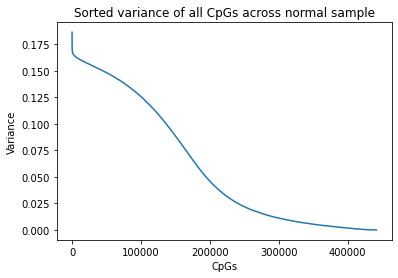

In [101]:
sorted_value=sorted(variance_allcpg,reverse=True)
x_label=range(0, len(variance_allcpg))
plt.figure()
plt.plot(x_label,sorted_value)
plt.xlabel('CpGs')
plt.ylabel('Variance')
plt.title('Sorted variance of all CpGs across normal sample')
plt.show()

In [ ]:
feature_distribution=Counter(beta_value['V1'][mask])

In [ ]:
plt.bar(list(dict(feature_distribution).keys()),list(dict(feature_distribution).values()))
# Add labels to your graph
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("Distribution of features")
plt.show()

In [74]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)

In [75]:
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9746835443037974


In [ ]:
ax = plt.gca()
rfc_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

[168, 4, 30, 48, 28, 43, 96, 40, 25, 70, 70, 10, 14, 4, 6, 12, 34, 88, 70]


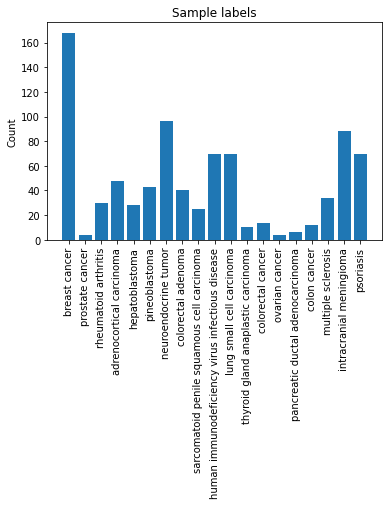

In [113]:
# Creating a bar plot
Y=disease_term[all_sample_index]
Y_distribution=Counter(Y)
plt.bar(list(dict(Y_distribution).keys()),list(dict(Y_distribution).values()))
print(list(dict(Y_distribution).values()))
# Add labels to your graph
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("Sample labels")
plt.show()

In [ ]:
disease_classify='cancer'
negative_sample_index=[[i for i in range(0,len(disease_term)) if ((disease_term[i]!=disease_classify) and (tissue_term[i]!='embryonic stem cell line' and tissue_term[i]!='MDA-MB-436 cell'))]]
positive_sample_index=[[i for i in range(0,len(disease_term)) if ((disease_term[i]==disease_classify) and (tissue_term[i]!='embryonic stem cell line' and tissue_term[i]!='MDA-MB-436 cell'))]]

In [104]:
print(len(metadata_value['disease_name']))

3560


In [43]:
def get_disease_indicator_matrix(node,sample_index):
    id_node=disease_id_to_name[node]
    ancestor_nodes=[i for i in sample_index if (metadata_value['disease_name'][i]!='normal' and metadata_value['disease_name'][i]!='adjacent normal' and metadata_value['disease_name'][i]!='adjacent normal' and disease_id_to_name[metadata_value['disease_name'][i]] in nx.descendants(disease_ontology_tree, id_node))]
    print(ancestor_nodes)
    positive_sample_index=[i for i in sample_index if metadata_value['disease_name'][i]!='normal' and metadata_value['disease_name'][i]!='adjacent normal' and metadata_value['disease_name'][i]!='adjacent normal' and disease_id_to_name[metadata_value['disease_name'][i]] not in nx.descendants(disease_ontology_tree, id_node) and (disease_id_to_name[metadata_value['disease_name'][i]] in nx.ancestors(disease_ontology_tree, id_node) or disease_id_to_name[metadata_value['disease_name'][i]]==id_node)]
    y_matrix=np.zeros(((len(metadata_value['disease_name'])), 1))
    y_matrix[positive_sample_index]=1
    samples_keep=list(set(sample_index)-set(ancestor_nodes))
    y_matrix_sample=y_matrix[samples_keep]
    return(y_matrix_sample,samples_keep,positive_sample_index)

In [109]:
disease_ontology_tree=obonet.read_obo('./../annotation/doid.obo')
all_sample_index=[i for i in range(0,len(metadata_value['disease_name'])) if (metadata_value['sample_id'][i] in overlap and disease_term[i]!='normal-altered' and disease_term[i]!='Hutchinson-Gilford progeria syndrome' and disease_term[i]!='Parkinsons disease' and disease_term[i]!='adjacent normal' and disease_term[i]!='normal' and disease_term[i]!='breast cancer-altered' and disease_term[i]!='normal-treated' and disease_term[i]!='T-cell lymphoblastic lymphoma' and disease_term[i]!='Williams syndrome')]
all_sample_value=[disease_term[i] for i in range(0,len(metadata_value['disease_name'])) if (metadata_value['sample_id'][i] in overlap and disease_term[i]!='normal-altered' and disease_term[i]!='Hutchinson-Gilford progeria syndrome' and disease_term[i]!='Parkinsons disease' and disease_term[i]!='adjacent normal' and disease_term[i]!='normal' and disease_term[i]!='breast cancer-altered' and disease_term[i]!='normal-treated' and disease_term[i]!='T-cell lymphoblastic lymphoma' and disease_term[i]!='Williams syndrome')]

In [106]:
print(set(disease_term))

{'pancreatic ductal adenocarcinoma', 'neuroendocrine tumor', 'lung small cell carcinoma', 'Hutchinson-Gilford progeria syndrome', 'normal-treated', 'normal', 'sarcomatoid penile squamous cell carcinoma', 'Williams syndrome', 'Parkinsons disease', 'prostate cancer', 'adjacent normal', 'hepatoblastoma', 'thyroid gland anaplastic carcinoma', 'colorectal adenoma', 'colon cancer', 'ovarian cancer', 'breast cancer', 'intracranial meningioma', 'pineoblastoma', 'adrenocortical carcinoma', 'multiple sclerosis', 'normal-altered', 'T-cell lymphoblastic lymphoma', 'colorectal cancer', 'breast cancer-altered', 'human immunodeficiency virus infectious disease', 'psoriasis', 'rheumatoid arthritis'}


In [41]:
disease_id_to_name = { data.get('name'):id_ for id_, data in disease_ontology_tree.nodes(data=True)}


In [57]:
print(len(all_sample_index))

263


In [ ]:
[disease_matrix_sample,disease_ancestor_nodes,disease_positive_sample_index]=get_disease_indicator_matrix('rheumatoid arthritis',all_sample_index)

pancreatic ductal adenocarcinoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[5.]
[1.]
[6.]
Accuracy: 0.9964788732394366
[['CTNNBIP1'], ['PDGFA'], ['RP11-360P21.2'], ['HMSD'], ['EFNA3'], ['RAMP3'], ['TSSC4'], ['SPSB1'], ['TERF2IP'], [], [], ['BIN1'], ['AIM2'], ['MAGI2'], ['RNF125'], [], ['QKI'], [], [], []]
[['ENSG00000178585'], ['ENSG00000197461'], ['ENSG00000229102'], ['ENSG00000221887'], ['ENSG00000251246'], ['ENSG00000122679'], ['ENSG00000184281'], ['ENSG00000171621'], ['ENSG00000166848'], [], [], ['ENSG00000136717'], ['ENSG00000163568'], ['ENSG00000187391'], ['ENSG00000101695'], [], ['ENSG00000112531'], [], [], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


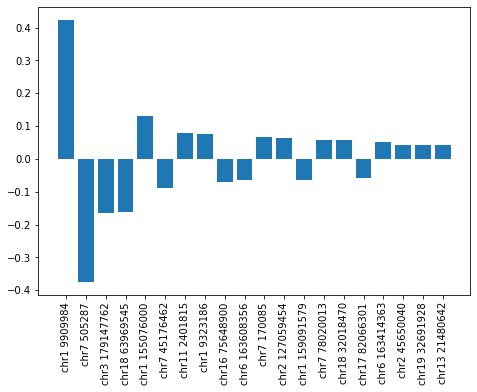

AUC:0.9964664310954063
neuroendocrine tumor
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[58.]
[38.]
[96.]
Accuracy: 0.9964788732394366
[['RP11-360P21.2'], ['RNF125'], ['RP11-253M7.1'], ['ADAR'], [], [], [], ['ALYREF'], ['HNRNPL'], ['CTNNA2'], ['TRAPPC3L'], ['OSCP1'], ['RPA1'], [], ['NBPF1'], ['DTX1'], ['CMPK1'], [], ['EDEM3'], ['GORASP1']]
[['ENSG00000229102'], ['ENSG00000101695'], ['ENSG00000259426'], ['ENSG00000160710'], [], [], [], ['ENSG00000183684'], ['ENSG00000104824'], ['ENSG00000066032'], ['ENSG00000173626'], ['ENSG00000116885'], ['ENSG00000132383'], [], ['ENSG00000219481'], ['ENSG00000135144'], ['ENSG00000162368'], [], ['ENSG00000116406'], ['ENSG00000114745']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


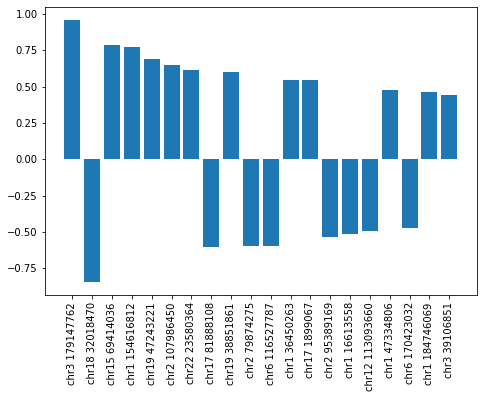

AUC:0.995079161317929
lung small cell carcinoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[46.]
[24.]
[70.]
Accuracy: 1.0
[['BIN1'], ['AC007743.1', 'CCDC85A', 'RP11-482H16.1'], ['BRE', 'MRPL33'], ['NBPF1'], ['RP11-360P21.2'], ['SYNPR'], ['RABGAP1L'], ['SPSB1'], [], [], [], [], ['SBK1'], ['SOCS5'], ['LIN54'], ['GSTM4'], ['SFXN5'], [], ['MYH9'], ['TRHDE', 'TRHDE-AS1']]
[['ENSG00000136717'], ['ENSG00000055813', 'ENSG00000233251', 'ENSG00000271894'], ['ENSG00000158019', 'ENSG00000243147'], ['ENSG00000219481'], ['ENSG00000229102'], ['ENSG00000163630'], ['ENSG00000152061'], ['ENSG00000171621'], [], [], [], [], ['ENSG00000188322'], ['ENSG00000171150'], ['ENSG00000189308'], ['ENSG00000168765'], ['ENSG00000144040'], [], ['ENSG00000100345'], ['ENSG00000072657', 'ENSG00000236333']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


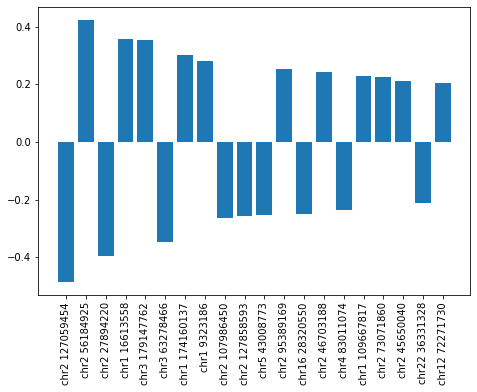

AUC:1.0
sarcomatoid penile squamous cell carcinoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[18.]
[7.]
[25.]
Accuracy: 0.9823943661971831
[['ADAR'], ['SALL3'], ['TERF2IP'], ['ZFP36L2'], ['EFNA3'], [], [], ['BIN1'], ['SOCS5'], ['SPSB1'], ['ALYREF'], ['PCNP'], ['METTL3'], [], ['PRPF38AP1'], ['CARD14'], ['CTNNBIP1'], [], ['AIM2'], ['PMPCA']]
[['ENSG00000160710'], ['ENSG00000256463'], ['ENSG00000166848'], ['ENSG00000152518'], ['ENSG00000251246'], [], [], ['ENSG00000136717'], ['ENSG00000171150'], ['ENSG00000171621'], ['ENSG00000183684'], ['ENSG00000081154'], ['ENSG00000165819'], [], ['ENSG00000225053'], ['ENSG00000141527'], ['ENSG00000178585'], [], ['ENSG00000163568'], ['ENSG00000165688']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


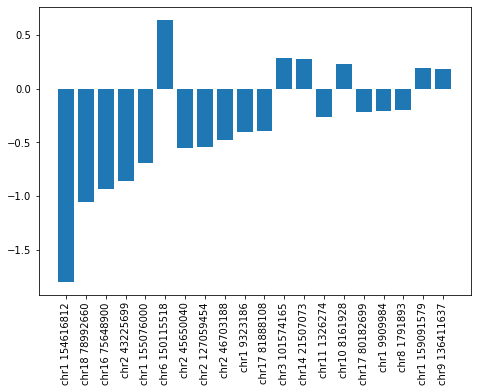

AUC:0.9969056214543579
prostate cancer
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[4.]
[0.]
[4.]
Accuracy: 1.0


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[], [], ['SH2D6'], [], ['PMPCA'], ['NBPF1'], ['EFNA3'], ['SPSB1'], ['LINC00315'], ['AFF3'], ['AC007743.1', 'CCDC85A', 'RP11-482H16.1'], ['RP11-134D3.1'], [], ['SARS'], ['TRAPPC3L'], ['ADAR'], ['RP11-360P21.2'], ['AGBL4', 'RP11-141A19.2'], ['DCTN1', 'DCTN1-AS1'], ['LINC01021']]
[[], [], ['ENSG00000152292'], [], ['ENSG00000165688'], ['ENSG00000219481'], ['ENSG00000251246'], ['ENSG00000171621'], ['ENSG00000184274'], ['ENSG00000144218'], ['ENSG00000055813', 'ENSG00000233251', 'ENSG00000271894'], ['ENSG00000232190'], [], ['ENSG00000031698'], ['ENSG00000173626'], ['ENSG00000160710'], ['ENSG00000229102'], ['ENSG00000186094', 'ENSG00000230114'], ['ENSG00000204843', 'ENSG00000237737'], ['ENSG00000250337']]


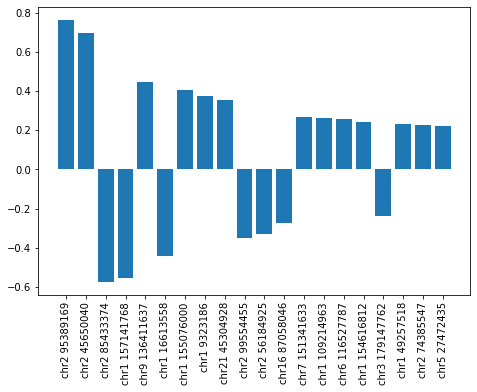

AUC:nan
hepatoblastoma
[]


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


(860, 1)
(860, 441683)
213
chr1 9909984
[17.]
[11.]
[28.]
Accuracy: 0.9964788732394366
[['RNF125'], [], ['RP11-536G4.2'], ['PTPRN2'], ['ADAR'], ['NOP2'], [], [], ['HNRNPL'], ['GORASP1'], ['TRAPPC3L'], ['PDGFA'], ['LRRN2'], ['CTNNA2'], ['MRPL41'], [], ['SFXN5'], ['NAV1'], ['RP11-360P21.2'], []]
[['ENSG00000101695'], [], ['ENSG00000258343'], ['ENSG00000155093'], ['ENSG00000160710'], ['ENSG00000111641'], [], [], ['ENSG00000104824'], ['ENSG00000114745'], ['ENSG00000173626'], ['ENSG00000197461'], ['ENSG00000170382'], ['ENSG00000066032'], ['ENSG00000182154'], [], ['ENSG00000144040'], ['ENSG00000134369'], ['ENSG00000229102'], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


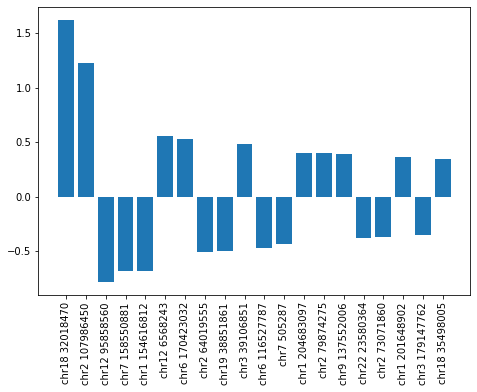

AUC:1.0
thyroid gland anaplastic carcinoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[9.]
[1.]
[10.]
Accuracy: 0.9964788732394366
[['TRAPPC3L'], ['SARS'], [], ['LPHN2'], ['RAMP3'], ['HNRNPL'], ['ADAR'], ['CLIC1'], ['PDGFA'], ['RP11-360P21.2'], ['ARMC9'], ['DCTN1', 'DCTN1-AS1'], ['CMPK1'], ['DCAF16'], ['EFNA3'], ['MAFA'], ['EDEM3'], [], ['SNX1'], ['RAB33B']]
[['ENSG00000173626'], ['ENSG00000031698'], [], ['ENSG00000117114'], ['ENSG00000122679'], ['ENSG00000104824'], ['ENSG00000160710'], ['ENSG00000213719'], ['ENSG00000197461'], ['ENSG00000229102'], ['ENSG00000135931'], ['ENSG00000204843', 'ENSG00000237737'], ['ENSG00000162368'], ['ENSG00000163257'], ['ENSG00000251246'], ['ENSG00000182759'], ['ENSG00000116406'], [], ['ENSG00000028528'], ['ENSG00000172007']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


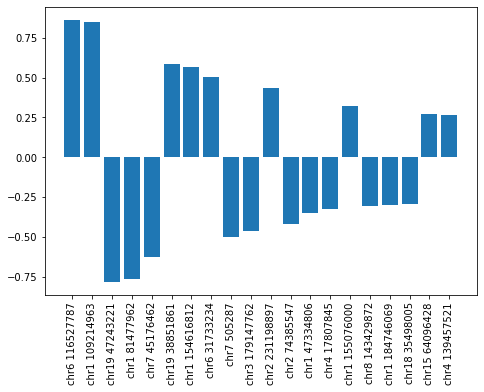

AUC:0.9964664310954063
colorectal adenoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[31.]
[9.]
[40.]
Accuracy: 0.9683098591549296
[['RP11-360P21.2'], ['RAMP3'], [], ['TRAPPC3L'], ['ADAR'], ['RP11-305P22.9'], ['BIN1'], ['PDGFA'], ['PMPCA'], ['NOP2'], ['SOCS5'], ['TERF2IP'], [], ['RNF125'], ['EFNA3'], ['SPSB1'], ['AATK'], ['AFF3'], ['NBPF1'], []]
[['ENSG00000229102'], ['ENSG00000122679'], [], ['ENSG00000173626'], ['ENSG00000160710'], ['ENSG00000272259'], ['ENSG00000136717'], ['ENSG00000197461'], ['ENSG00000165688'], ['ENSG00000111641'], ['ENSG00000171150'], ['ENSG00000166848'], [], ['ENSG00000101695'], ['ENSG00000251246'], ['ENSG00000171621'], ['ENSG00000181409'], ['ENSG00000144218'], ['ENSG00000219481'], []]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


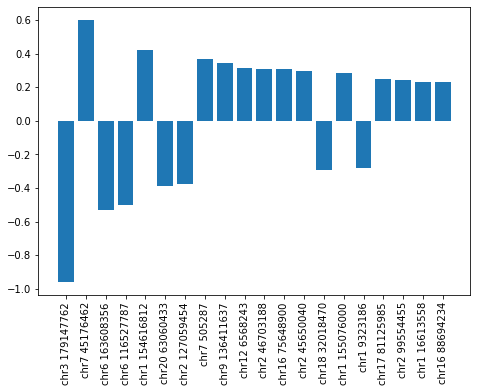

AUC:1.0
colon cancer
[1341, 1342, 1349, 1350, 1352, 1353, 1354, 1355, 1356, 1357, 1359, 1364, 1365, 1366]
(846, 1)
(846, 441683)
567
chr1 2293668
[9.]
[3.]
[12.]
Accuracy: 1.0
[['RPA3'], ['KDM4B'], [], [], ['PSME4'], ['ADAR'], ['PRDM16'], ['AC074391.1'], ['ATIC'], ['ZFP36L2'], ['AC016700.3', 'AC016700.4'], ['SARS'], ['LINC00315'], ['GSTM4'], ['PLEKHG7'], ['BIN1'], ['TRAPPC3L'], ['CASZ1'], ['CMPK1'], ['SNX1']]
[['ENSG00000106399'], ['ENSG00000127663'], [], [], ['ENSG00000068878'], ['ENSG00000160710'], ['ENSG00000142611'], ['ENSG00000204929'], ['ENSG00000138363'], ['ENSG00000152518'], ['ENSG00000225392', 'ENSG00000226505'], ['ENSG00000031698'], ['ENSG00000184274'], ['ENSG00000168765'], ['ENSG00000187510'], ['ENSG00000136717'], ['ENSG00000173626'], ['ENSG00000130940'], ['ENSG00000162368'], ['ENSG00000028528']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


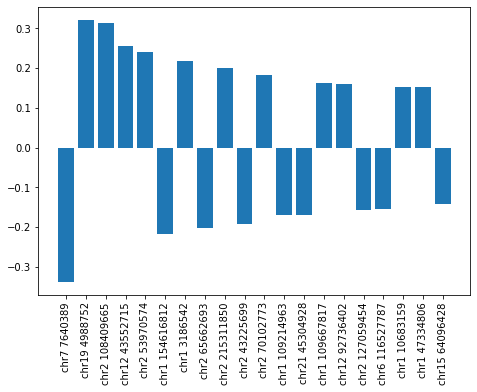

AUC:1.0
ovarian cancer
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[1.]
[3.]
[4.]
Accuracy: 0.9894366197183099
[[], ['ARPP21'], ['CASZ1'], ['GORASP1'], ['EFCAB11', 'RP11-33N16.3'], [], [], ['CTNNA2'], ['DCAF16'], [], ['HOMER2'], ['PDGFA'], ['ADAR'], ['RNF125'], ['MAFA'], ['RAB33B'], ['PALLD'], ['RHPN1'], [], ['TERF2IP']]
[[], ['ENSG00000172995'], ['ENSG00000130940'], ['ENSG00000114745'], ['ENSG00000140025', 'ENSG00000259053'], [], [], ['ENSG00000066032'], ['ENSG00000163257'], [], ['ENSG00000103942'], ['ENSG00000197461'], ['ENSG00000160710'], ['ENSG00000101695'], ['ENSG00000182759'], ['ENSG00000172007'], ['ENSG00000129116'], ['ENSG00000158106'], [], ['ENSG00000166848']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


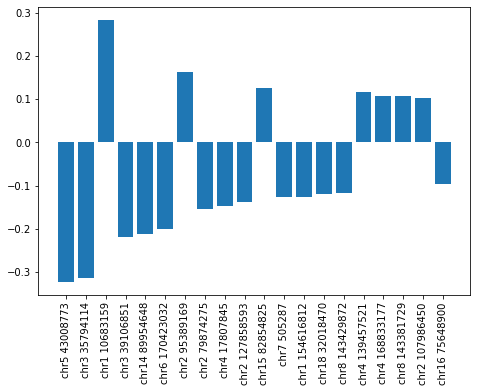

AUC:1.0
breast cancer
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[104.]
[64.]
[168.]
Accuracy: 0.9859154929577465
[[], ['RAMP3'], ['LINC00315'], ['EFNA3'], ['MPDZ'], ['SH2D6'], ['ARMC9'], ['RPA1'], [], [], ['AC079305.8'], ['BIN1'], ['ASF1B'], ['PARP8'], ['ADAR'], ['PSTPIP1'], ['METTL3'], ['RP13-131K19.2'], [], ['HNRNPL']]
[[], ['ENSG00000122679'], ['ENSG00000184274'], ['ENSG00000251246'], ['ENSG00000107186'], ['ENSG00000152292'], ['ENSG00000135931'], ['ENSG00000132383'], [], [], ['ENSG00000229337'], ['ENSG00000136717'], ['ENSG00000105011'], ['ENSG00000151883'], ['ENSG00000160710'], ['ENSG00000140368'], ['ENSG00000165819'], ['ENSG00000223343'], [], ['ENSG00000104824']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


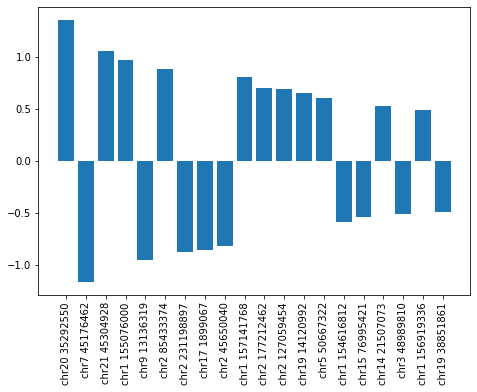

AUC:0.9944602272727273
intracranial meningioma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[56.]
[32.]
[88.]
Accuracy: 0.9964788732394366
[[], ['SARS'], ['ADAR'], [], ['ALYREF'], ['BRE', 'MRPL33'], ['RAMP3'], ['NAV1'], ['HNRNPL'], ['RAB33B'], [], ['EFNA3'], ['SFXN5'], ['PMPCA'], ['LINC00315'], [], ['CTNNBIP1'], ['RNF125'], ['SYNPR'], ['RP11-253M7.1']]
[[], ['ENSG00000031698'], ['ENSG00000160710'], [], ['ENSG00000183684'], ['ENSG00000158019', 'ENSG00000243147'], ['ENSG00000122679'], ['ENSG00000134369'], ['ENSG00000104824'], ['ENSG00000172007'], [], ['ENSG00000251246'], ['ENSG00000144040'], ['ENSG00000165688'], ['ENSG00000184274'], [], ['ENSG00000178585'], ['ENSG00000101695'], ['ENSG00000163630'], ['ENSG00000259426']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


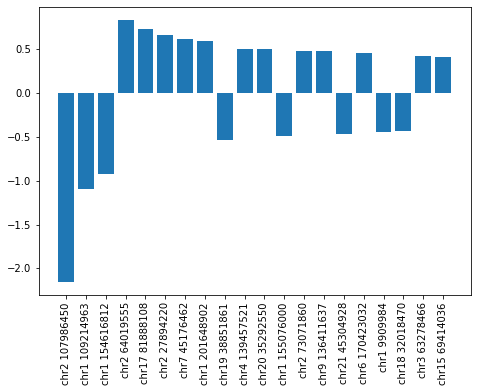

AUC:0.9899553571428572
pineoblastoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[31.]
[12.]
[43.]
Accuracy: 1.0
[[], ['PSTPIP1'], ['AC007743.1', 'CCDC85A', 'RP11-482H16.1'], [], [], ['ADAR'], ['HOMER2'], ['OTOF'], ['PARP8'], ['MAGI2'], [], [], ['SH2D5'], ['MPDZ'], ['RP11-536G4.2'], ['ALDH1L1', 'ALDH1L1-AS2'], ['SLC1A3'], [], ['AIM2'], ['GSTM4']]
[[], ['ENSG00000140368'], ['ENSG00000055813', 'ENSG00000233251', 'ENSG00000271894'], [], [], ['ENSG00000160710'], ['ENSG00000103942'], ['ENSG00000115155'], ['ENSG00000151883'], ['ENSG00000187391'], [], [], ['ENSG00000189410'], ['ENSG00000107186'], ['ENSG00000258343'], ['ENSG00000144908', 'ENSG00000246022'], ['ENSG00000079215'], [], ['ENSG00000163568'], ['ENSG00000168765']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


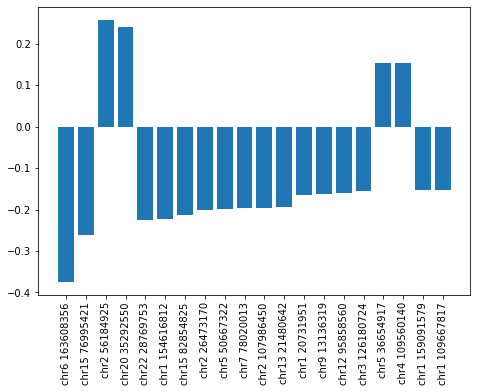

AUC:1.0
adrenocortical carcinoma
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[34.]
[14.]
[48.]
Accuracy: 1.0
[['RP11-253M7.1'], ['GORASP1'], ['RAB33B'], ['LINC01021'], ['ADAR'], [], ['SARS'], ['HNRNPL'], ['AGBL4', 'RP11-141A19.2'], ['OTOF'], ['CMPK1'], ['RPA1'], ['METTL3'], [], ['DCAF16'], [], ['RP11-360P21.2'], ['PTPRN2'], [], ['SPSB1']]
[['ENSG00000259426'], ['ENSG00000114745'], ['ENSG00000172007'], ['ENSG00000250337'], ['ENSG00000160710'], [], ['ENSG00000031698'], ['ENSG00000104824'], ['ENSG00000186094', 'ENSG00000230114'], ['ENSG00000115155'], ['ENSG00000162368'], ['ENSG00000132383'], ['ENSG00000165819'], [], ['ENSG00000163257'], [], ['ENSG00000229102'], ['ENSG00000155093'], [], ['ENSG00000171621']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


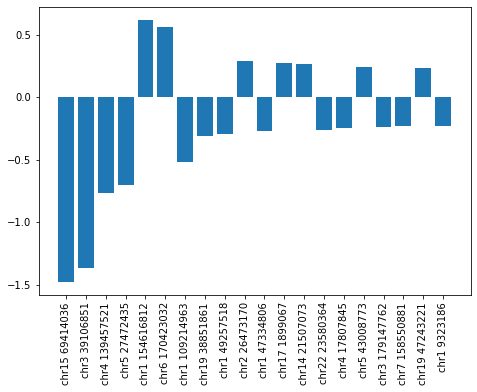

AUC:1.0
multiple sclerosis
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[25.]
[9.]
[34.]
Accuracy: 1.0
[[], ['RAMP3'], ['ASF1B'], ['PARP8'], [], ['MAP3K9'], ['PSTPIP1'], ['PDGFA'], ['LRRN2'], ['ARPP21'], [], ['MAGI2'], ['SARS'], ['NAV1'], ['METTL3'], [], ['EDEM3'], ['DTX1'], [], ['ADAR']]
[[], ['ENSG00000122679'], ['ENSG00000105011'], ['ENSG00000151883'], [], ['ENSG00000006432'], ['ENSG00000140368'], ['ENSG00000197461'], ['ENSG00000170382'], ['ENSG00000172995'], [], ['ENSG00000187391'], ['ENSG00000031698'], ['ENSG00000134369'], ['ENSG00000165819'], [], ['ENSG00000116406'], ['ENSG00000135144'], [], ['ENSG00000160710']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


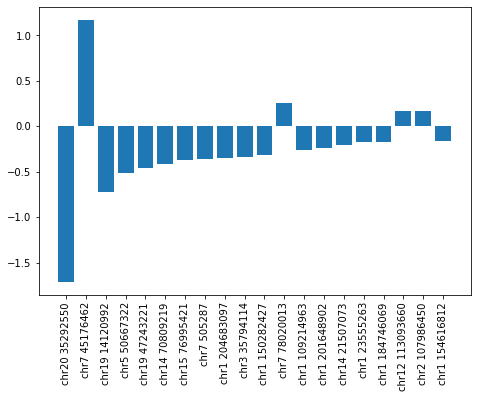

AUC:1.0
colorectal cancer
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[21.]
[5.]
[26.]
Accuracy: 0.9964788732394366
[[], [], ['AFF3'], ['AC074391.1'], ['LINC00315'], [], [], [], ['CMPK1'], ['RP11-360P21.2'], ['SARS'], ['ZFP36L2'], ['LRRN2'], ['SBK1'], ['DCTN1', 'DCTN1-AS1'], ['SNX1'], ['GSTM4'], ['SOCS5'], ['RNF125'], ['OSCP1']]
[[], [], ['ENSG00000144218'], ['ENSG00000204929'], ['ENSG00000184274'], [], [], [], ['ENSG00000162368'], ['ENSG00000229102'], ['ENSG00000031698'], ['ENSG00000152518'], ['ENSG00000170382'], ['ENSG00000188322'], ['ENSG00000204843', 'ENSG00000237737'], ['ENSG00000028528'], ['ENSG00000168765'], ['ENSG00000171150'], ['ENSG00000101695'], ['ENSG00000116885']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


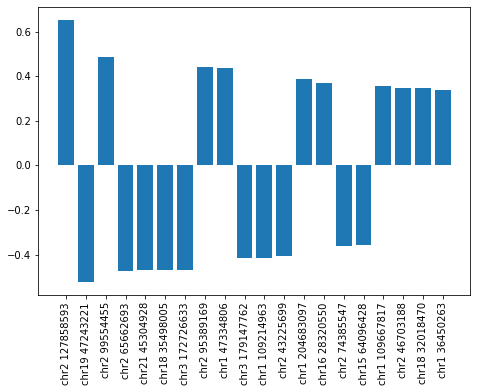

AUC:0.978494623655914
human immunodeficiency virus infectious disease
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[52.]
[18.]
[70.]
Accuracy: 0.9366197183098591
[[], ['METTL3'], ['NBPF1'], ['RP11-360P21.2'], ['PRPF38AP1'], ['SARS'], ['TRAPPC3L'], ['MAFA'], ['RPA1'], [], ['VPS37C'], [], ['C4orf51'], ['FRS2'], [], ['PMPCA'], ['PSTPIP1'], ['LTBR'], ['SNX1'], ['SSTR3']]
[[], ['ENSG00000165819'], ['ENSG00000219481'], ['ENSG00000229102'], ['ENSG00000225053'], ['ENSG00000031698'], ['ENSG00000173626'], ['ENSG00000182759'], ['ENSG00000132383'], [], ['ENSG00000167987'], [], ['ENSG00000237136'], ['ENSG00000166225'], [], ['ENSG00000165688'], ['ENSG00000140368'], ['ENSG00000111321'], ['ENSG00000028528'], ['ENSG00000278195']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


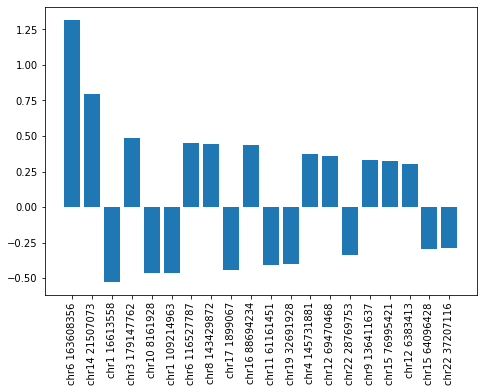

AUC:0.9920634920634921
psoriasis
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[45.]
[25.]
[70.]
Accuracy: 0.9119718309859155
[['PMPCA'], [], [], ['SNCB'], ['SFXN5'], ['GORASP1'], ['SPSB1'], ['PTPRN2'], ['LRBA'], ['GSE1'], [], ['ALYREF'], [], ['RHPN1'], ['EFNA3'], ['SARS'], ['RNF125'], ['SHANK2'], ['SNX1'], ['TRAPPC9']]
[['ENSG00000165688'], [], [], ['ENSG00000074317'], ['ENSG00000144040'], ['ENSG00000114745'], ['ENSG00000171621'], ['ENSG00000155093'], ['ENSG00000198589'], ['ENSG00000131149'], [], ['ENSG00000183684'], [], ['ENSG00000158106'], ['ENSG00000251246'], ['ENSG00000031698'], ['ENSG00000101695'], ['ENSG00000162105'], ['ENSG00000028528'], ['ENSG00000167632']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


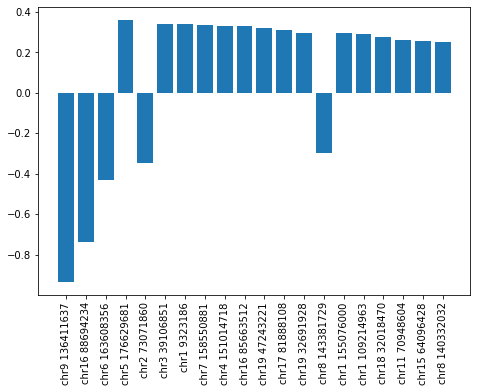

AUC:0.9961389961389961
rheumatoid arthritis
[]
(860, 1)
(860, 441683)
213
chr1 9909984
[19.]
[11.]
[30.]
Accuracy: 0.9612676056338029
[['PGRMC2'], ['AC079305.8'], ['SH2D5'], ['SFXN5'], ['VPS37C'], ['SBK1'], [], ['METTL3'], ['RPA1'], ['CDK13'], ['EDEM3'], ['RAMP3'], [], ['EFNA3'], ['PSTPIP1'], [], ['TRAPPC3L'], ['BIN1'], ['DCTN1', 'DCTN1-AS1'], ['SPSB1']]
[['ENSG00000164040'], ['ENSG00000229337'], ['ENSG00000189410'], ['ENSG00000144040'], ['ENSG00000167987'], ['ENSG00000188322'], [], ['ENSG00000165819'], ['ENSG00000132383'], ['ENSG00000065883'], ['ENSG00000116406'], ['ENSG00000122679'], [], ['ENSG00000251246'], ['ENSG00000140368'], [], ['ENSG00000173626'], ['ENSG00000136717'], ['ENSG00000204843', 'ENSG00000237737'], ['ENSG00000171621']]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


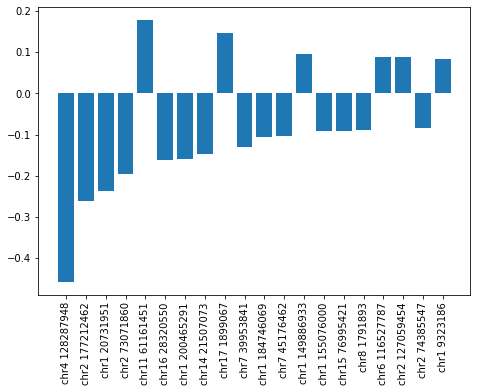

AUC:0.9813519813519813


In [112]:
all_genes=dict()
for i in set(all_sample_value):
    print(i)
    [y_matrix_single, samples_keep, positive_sample]=get_disease_indicator_matrix(i,all_sample_index)
    print(y_matrix_single.shape)
    x_matrix_single=beta_value[metadata_value.iloc[samples_keep,0]]
    value_X=np.transpose(np.array(x_matrix_single))
    print(value_X.shape)
    sel = VarianceThreshold(threshold=(0.19))
    filtered_X=sel.fit_transform(value_X)
    mask = sel.get_support(indices=True)
    print(len(mask))
    filtered_labels=list(feature[mask])
    print(filtered_labels[1])
    X_train, X_test, y_train, y_test = train_test_split(filtered_X, y_matrix_single, test_size=0.33, random_state=42)
    print(sum(y_train))
    print(sum(y_test))
    print(sum(y_matrix_single))
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    coefficients=list(clf.coef_[0,:])
    coeffdict={coefficients[i]:filtered_labels[i] for i in range(0, len(coefficients))}
    coordinate_coeffdict={coefficients[i]:mask[i] for i in range(0, len(coefficients))}
    sorted_coeffs=sorted(coefficients, key=abs, reverse=True)
    CpGcoord20=[coordinate_coeffdict[key] for key in sorted_coeffs[0:20]]
    gene_names=[]
    gene_ids=[]
    for j in CpGcoord20:
        chromo=beta_value['V1'][j].split('chr')[1]
        CpGposition=beta_value['V2'][j]
        gene_names.append(data.gene_names_at_locus(contig=chromo, position=int(CpGposition)))
        gene_ids.append(data.gene_ids_at_locus(contig=chromo, position=int(CpGposition)))
    all_genes.update({i:gene_names})
    print(gene_names)
    print(gene_ids)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar([coeffdict[key] for key in sorted_coeffs[0:20]],sorted_coeffs[0:20])
    plt.xticks(rotation=90)
    plt.show()
    #y_prob=clf.predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    print('AUC:'+str(auc(fpr,tpr)))
    # Compute ROC curve and ROC area for each class
    #n_classes = y_matrix_single.shape[1]
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    #for i in range(n_classes):
        #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        #roc_auc[i] = auc(fpr[i], tpr[i])
#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()